In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

Using TensorFlow backend.


In [2]:
FAST_RUN = True
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)

### Preparing training data

In [3]:
path = '/Users/stanislav/data/cats_and_dogs/train/'
filenames = os.listdir(path)
labels = []
for file in filenames:
    label = file.split('.')[0]
    if label == 'cat':
        labels.append(0)
    else:
        labels.append(1)

In [4]:
print(len(filenames), ',', len(labels))

25000 , 25000


In [5]:
df = pd.DataFrame({
    'filename' : filenames,
    'label' : labels
})

In [6]:
display(df.head(), df.tail()) # how display them horizontally?

,filename,label
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


,filename,label
24995,dog.8008.jpg,1
24996,dog.1992.jpg,1
24997,dog.12412.jpg,1
24998,cat.2701.jpg,0
24999,cat.10148.jpg,0


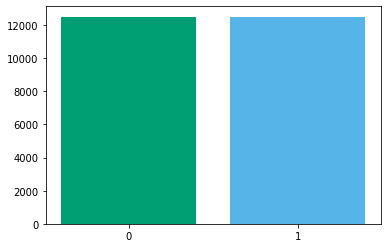

In [7]:
plt.bar('0', df['label'].value_counts()[0], color=("#009E73"))
plt.bar('1', df['label'].value_counts()[1], color=("#56B4E9"))
plt.show()

In [8]:
rand_df = pd.DataFrame({
    'A' : [1,2,3,4,5,6],
    'B' : [0,1,2,0,1,2]
})

In [9]:
xs = []
hs = []
for i in range(0, len(np.unique(rand_df.B))):
    xs.append(i)
    hs.append(rand_df[rand_df.B == i].B.value_counts()[i])

In [10]:
xs, hs

([0, 1, 2], [2, 2, 2])

In [11]:
rand_df[rand_df.B == 2].B.value_counts().shape, rand_df[rand_df.B == 2].B.value_counts()[2]

((1,), 2)

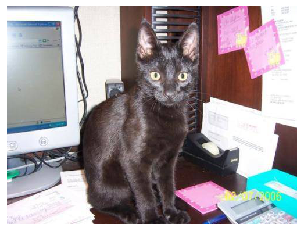

In [12]:
random_file = random.choice(filenames)
random_pic = load_img(path + random_file)
plt.imshow(random_pic)
plt.axis('off')
plt.show()

### Building a model

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(2, activation='softmax')
])

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

### Callbacks

In [16]:
earlystop = EarlyStopping(patience=10)

In [17]:
lear_rate_reduc = ReduceLROnPlateau(monitor='val_accuracy',
                                    patience=2,
                                    verbose=1,
                                    factor=0.5,
                                    min_lr=0.00001)

In [18]:
callbacks = [earlystop, lear_rate_reduc]

### Preparing and looking at data

In [19]:
# for class_mode=binary/categorical labels must be string
df['label'] = df['label'].replace({0 : 'cat', 1 : 'dog'})

In [20]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)

In [21]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

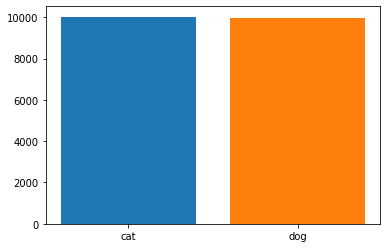

In [22]:
plt.bar('cat', train_df[train_df.label == 'cat'].label.value_counts())
plt.bar('dog', train_df[train_df.label == 'dog'].label.value_counts())
plt.show()

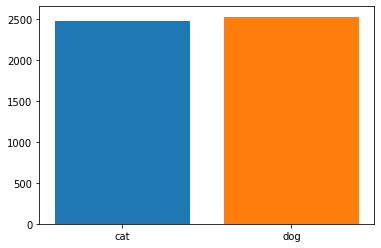

In [23]:
plt.bar('cat', validate_df[validate_df.label == 'cat'].label.value_counts())
plt.bar('dog', validate_df[validate_df.label == 'dog'].label.value_counts())
plt.show()

In [24]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Training Generator

In [25]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                  )

In [26]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    path,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=IMG_SIZE,
                                                    class_mode='categorical',
                                                    batch_size=batch_size, 
                                                    shuffle=True)

Found 20000 validated image filenames belonging to 2 classes.


### Validation generator

In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              path,
                                                              x_col='filename',
                                                              y_col='label',
                                                              target_size=IMG_SIZE,
                                                              class_mode='categorical',
                                                              batch_size=batch_size,
                                                              shuffle=True)

Found 5000 validated image filenames belonging to 2 classes.


### How generator works

In [29]:
rand_pic = train_df.sample(n=1).reset_index(drop=True)

In [30]:
pic_generator = train_datagen.flow_from_dataframe(rand_pic,
                                                  path,
                                                  x_col='filename',
                                                  y_col='label',
                                                  target_size=IMG_SIZE,
                                                  class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


In [31]:
x, y = next(pic_generator)
y.shape

(1, 1)

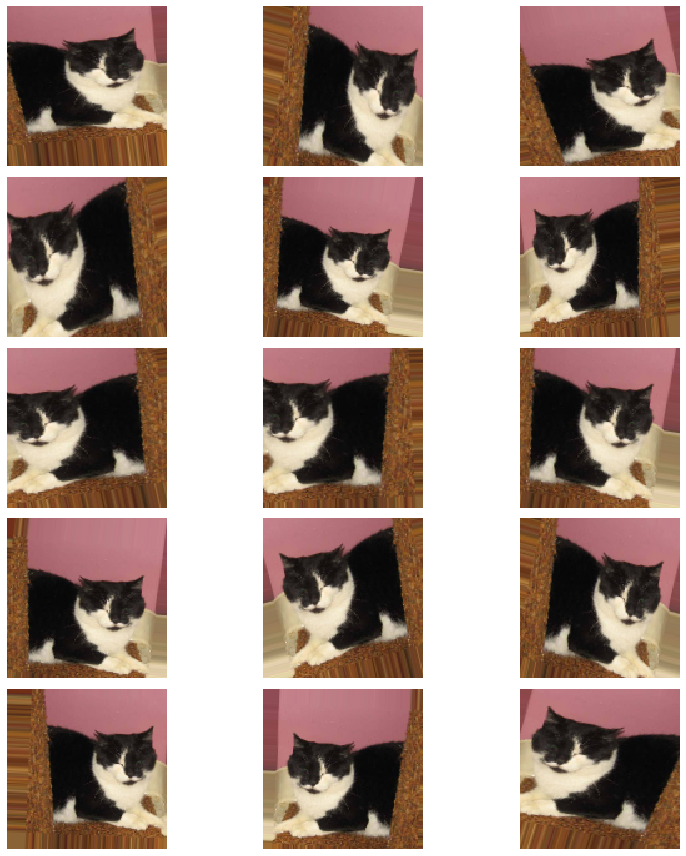

In [32]:
plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 3, i+1)
    for img, label in pic_generator:
        image = img[0]
        plt.imshow(image)
        plt.axis('off')
        break      
plt.tight_layout()
plt.show()

### Fit a model

In [33]:
model = load_model('/Users/Stanislav/model.h5')

In [35]:
epochs=3 if FAST_RUN else 30
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=total_validate // (batch_size),
                    steps_per_epoch=total_train // (batch_size),
                    callbacks=None)

Epoch 1/3
1333/1333 [==============================] - 851s 639ms/step - loss: 0.4350 - accuracy: 0.7982 - val_loss: 0.3856 - val_accuracy: 0.8314
Epoch 2/3
1333/1333 [==============================] - 833s 625ms/step - loss: 0.4487 - accuracy: 0.7876 - val_loss: 0.3603 - val_accuracy: 0.8394
Epoch 3/3
1333/1333 [==============================] - 805s 604ms/step - loss: 0.4199 - accuracy: 0.8067 - val_loss: 0.4608 - val_accuracy: 0.7928


In [36]:
#model.save('model_224.h5')

### Visualisize training

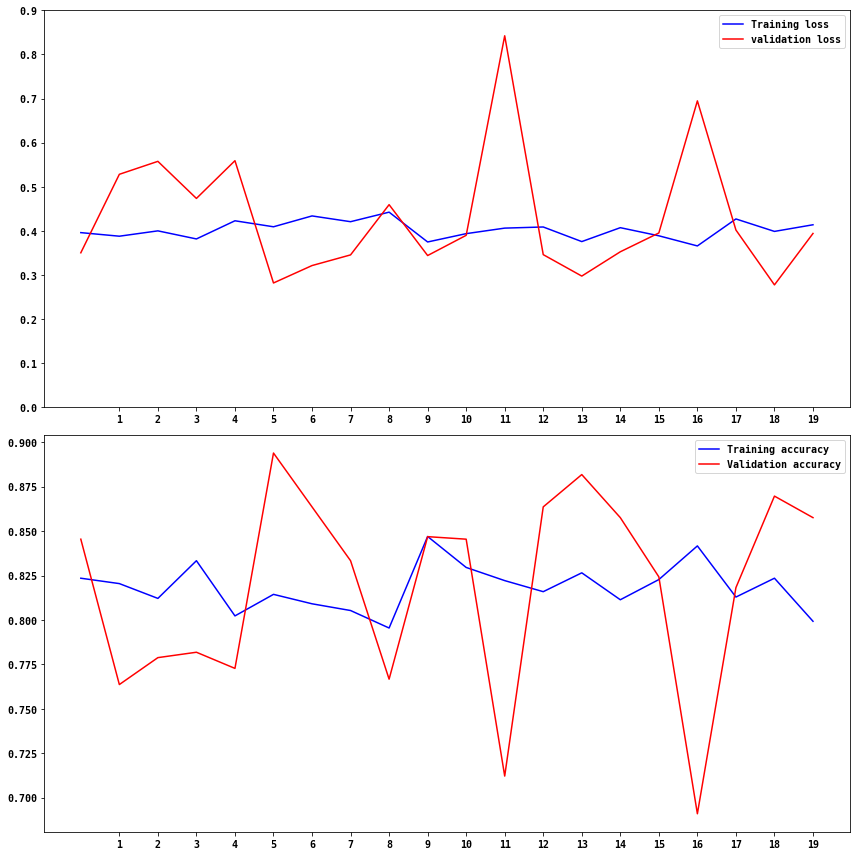

In [346]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size' : 10}
rc('font', **font)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 20, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 20, 1))

#legend = plt.legend(loc='best', shadow=True)
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.tight_layout()
plt.show()

### Prepare testing data

In [37]:
test_path = '/Users/stanislav/data/cats_and_dogs/test/'
test_filenames = os.listdir('/Users/stanislav/data/cats_and_dogs/test/')
test_df = pd.DataFrame({
    'filename' : test_filenames
})

In [38]:
test_filenames

['MUOl1U826ho.jpg',
 '.DS_Store',
 'tTMxGr0o0og.jpg',
 'qpU1s6YkaPM.jpg',
 'YxU074NNcfI.jpg',
 '7steWZCOFu8.jpg',
 'PAvmOY6Voqo.jpg',
 'WT9dXFJbwNk.jpg',
 'KA94GiXXB9U.jpg',
 'dHJDcTTXwOg.jpg',
 'L_EVioanNLc.jpg',
 'EV3HlF8qoGc.jpg',
 'ukbMPQaE12M.jpg']

In [39]:
test_df = test_df.drop([1])

In [40]:
test_df

,filename
0,MUOl1U826ho.jpg
2,tTMxGr0o0og.jpg
3,qpU1s6YkaPM.jpg
4,YxU074NNcfI.jpg
5,7steWZCOFu8.jpg
6,PAvmOY6Voqo.jpg
7,WT9dXFJbwNk.jpg
8,KA94GiXXB9U.jpg
9,dHJDcTTXwOg.jpg
10,L_EVioanNLc.jpg


In [41]:
nb_sample = test_df.shape[0]
nb_sample

12

In [42]:
test_df.iloc[0][:]

filename    MUOl1U826ho.jpg
Name: 0, dtype: object

### Create testing generator

In [43]:
test_gen = ImageDataGenerator(rescale=1./255)

In [44]:
test_generator = test_gen.flow_from_dataframe(test_df,
                                              test_path,
                                              x_col='filename',
                                              y_col=None,
                                              class_mode=None,
                                              target_size=IMG_SIZE,
                                              batch_size=nb_sample)

Found 12 validated image filenames.


### Predicting

In [45]:
predict = model.predict(test_generator[0])

In [46]:
for i in predict:
    if i[0] > i[1]:
        print('С вероятностью ', np.round(i[0]*100, decimals=2), '% на фото изображена собака.')
    elif i[1] > i[0]:
        print('С вероятностью ', np.round(i[1]*100, decimals=2), '% на фото изображена кошка.')

С вероятностью  93.32 % на фото изображена собака.
С вероятностью  53.55 % на фото изображена собака.
С вероятностью  75.3 % на фото изображена собака.
С вероятностью  88.61 % на фото изображена собака.
С вероятностью  58.76 % на фото изображена кошка.
С вероятностью  93.58 % на фото изображена кошка.
С вероятностью  80.11 % на фото изображена кошка.
С вероятностью  90.29 % на фото изображена кошка.
С вероятностью  84.26 % на фото изображена собака.
С вероятностью  86.45 % на фото изображена собака.
С вероятностью  83.36 % на фото изображена собака.
С вероятностью  90.45 % на фото изображена собака.


In [49]:
from matplotlib.pyplot import rc
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size' : 15}
rc('font', **font)

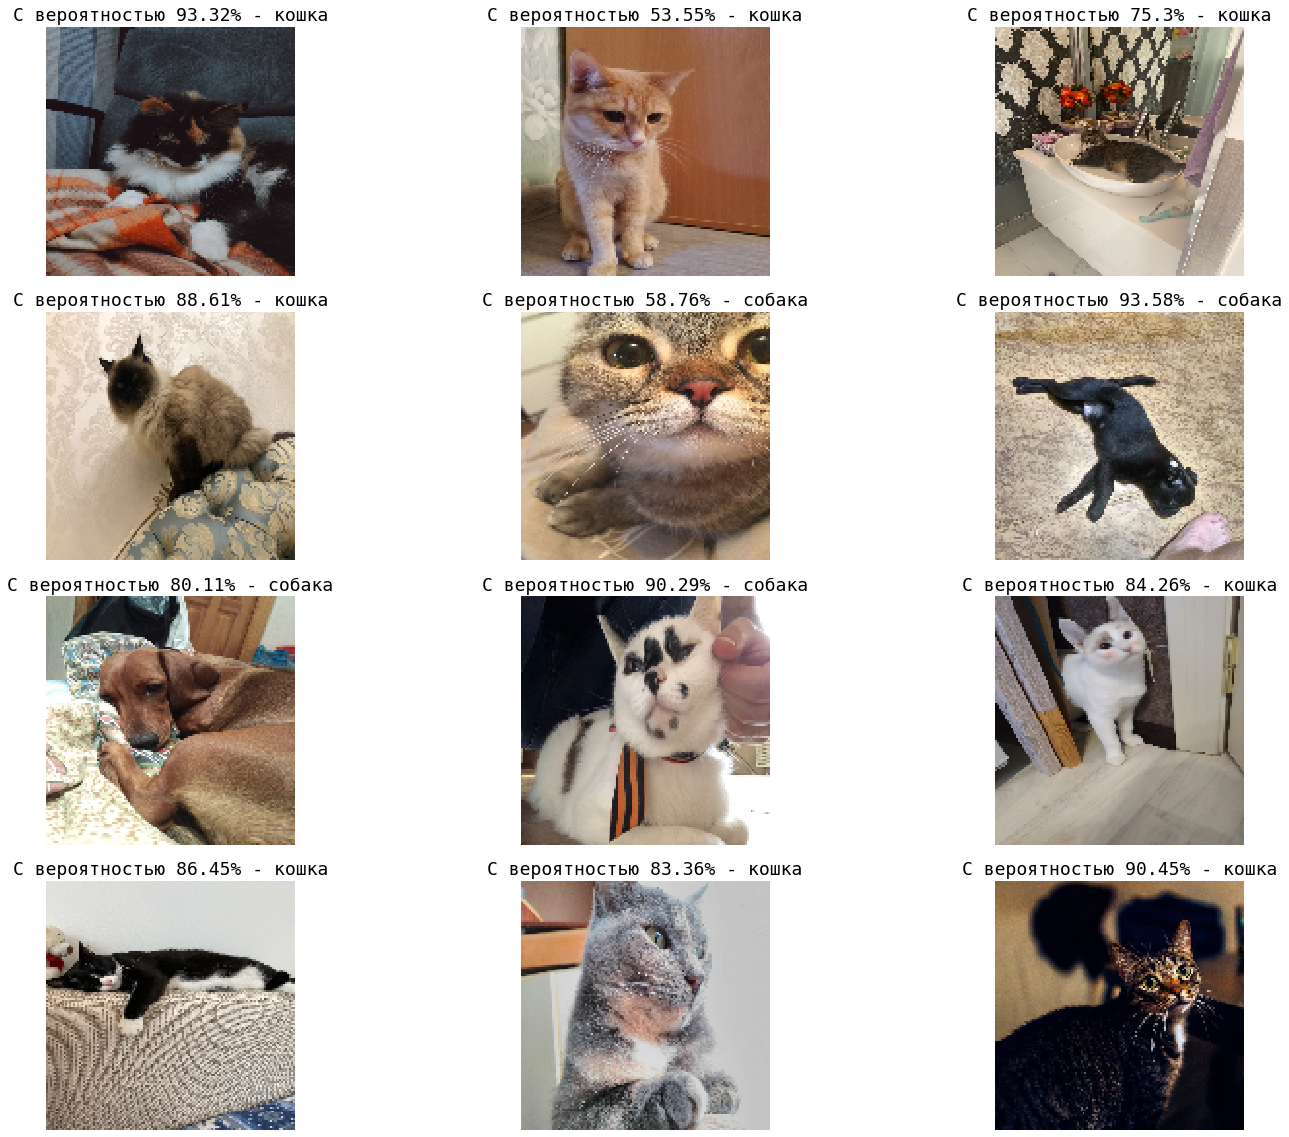

In [50]:
plt.figure(figsize=(20, 20))
for i in range(nb_sample):
    plt.subplot(nb_sample // 3 + 1, 3, i+1)
    image = test_generator[0][i]
    plt.imshow(image)
    plt.axis('off')
    
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)

    if prediction[0][0] > prediction[0][1]:
        plt.title('С вероятностью ' + str(np.round(prediction[0][0]*100, decimals=2)) + '% - кошка')
    elif prediction[0][1] > prediction[0][0]:
        plt.title('С вероятностью ' + str(np.round(prediction[0][1]*100, decimals=2)) + '% - собака')
    
plt.tight_layout()
plt.show()

### Addind pretrained model 

In [51]:
base_layers = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False)
base_layers.trainable = False

In [52]:
model_pretrained = tf.keras.Sequential([
                             base_layers,
                             GlobalAveragePooling2D(),
                             Dropout(0.2),
                             Dense(2, activation='softmax')
])

In [53]:
model_pretrained.compile(optimizer='rmsprop', 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])

In [54]:
history_pretrained = model_pretrained.fit(
                          train_generator,
                          epochs=1,
                          validation_data=validation_generator,
                          validation_steps=total_validate // (batch_size),
                          steps_per_epoch=total_train // (batch_size)
                          )

1333/1333 [==============================] - 468s 351ms/step - loss: 0.1693 - accuracy: 0.9343 - val_loss: 0.1069 - val_accuracy: 0.9616


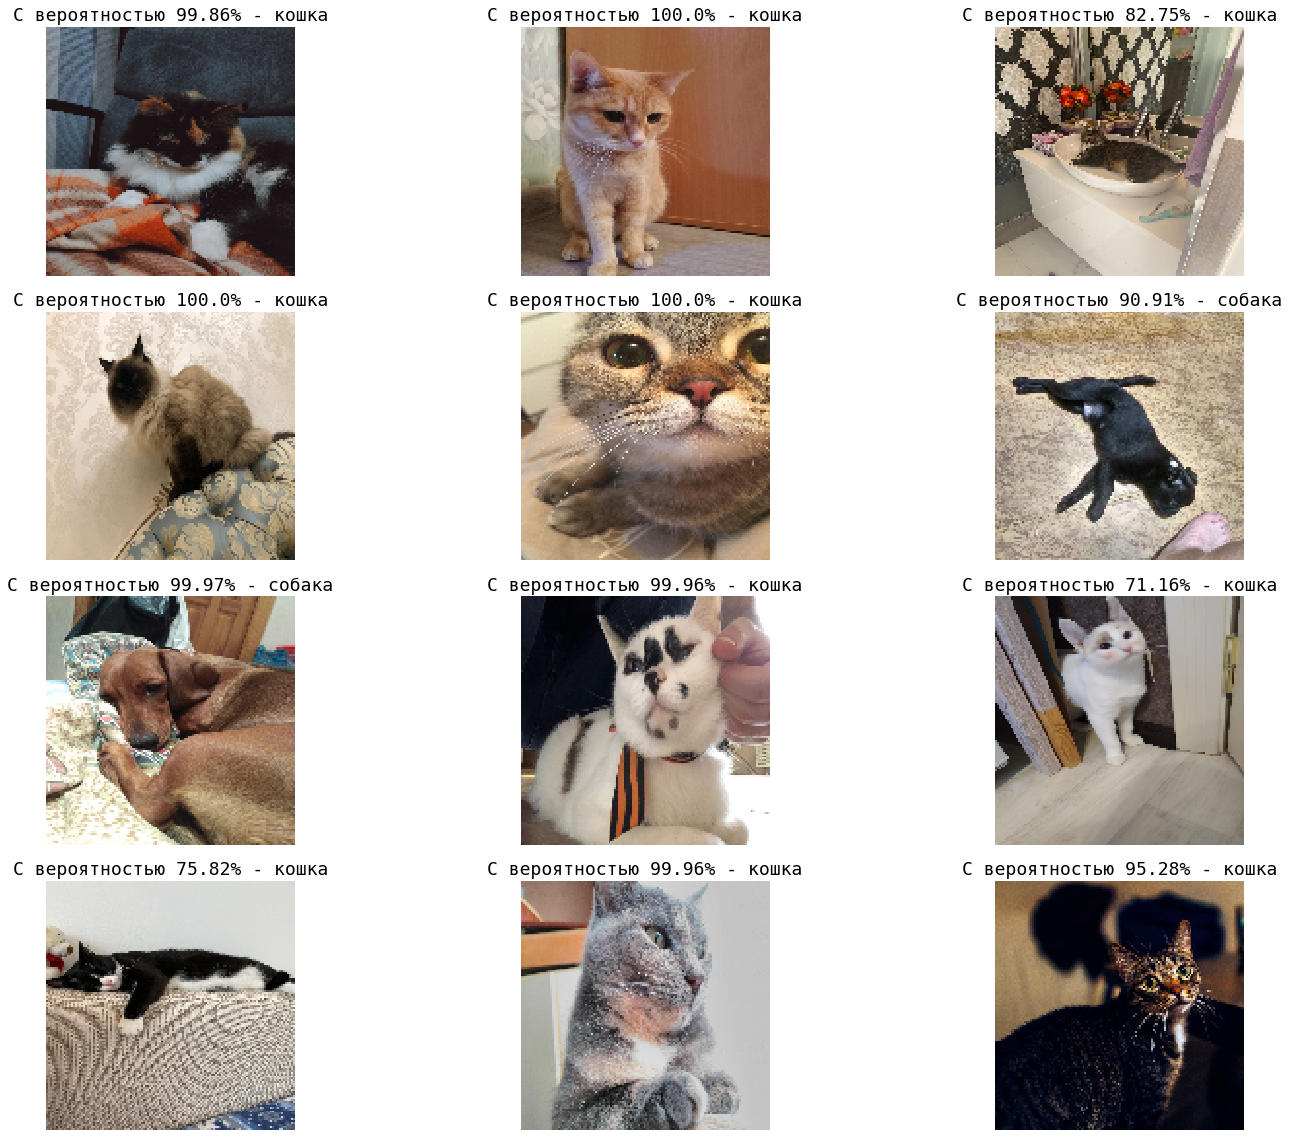

In [55]:
plt.figure(figsize=(20, 20))
for i in range(nb_sample):
    plt.subplot(nb_sample // 3 + 1, 3, i+1)
    image = test_generator[0][i]
    plt.imshow(image)
    plt.axis('off')
    
    image = np.expand_dims(image, axis=0)
    prediction = model_pretrained.predict(image)

    if prediction[0][0] > prediction[0][1]:
        plt.title('С вероятностью ' + str(np.round(prediction[0][0]*100, decimals=2)) + '% - кошка')
    elif prediction[0][1] > prediction[0][0]:
        plt.title('С вероятностью ' + str(np.round(prediction[0][1]*100, decimals=2)) + '% - собака')
    
plt.tight_layout()
plt.show()

### Strange moment with model_pretrained

In [56]:
example_path = '/Users/Stanislav/data/cats_and_dogs/example/'
example_files = os.listdir(example_path)

In [57]:
example_df = pd.DataFrame({
    'filename' : example_files
})

In [58]:
example_gen = ImageDataGenerator(rescale=1./255)

In [59]:
example_generator = example_gen.flow_from_dataframe(example_df,
                                                    example_path,
                                                    x_col='filename',
                                                    y_col=None,
                                                    target_size=IMG_SIZE,
                                                    class_mode=None,
                                                    batch_size=len(example_df),
                                                    shuffle=True
                                                    )

Found 2 validated image filenames.


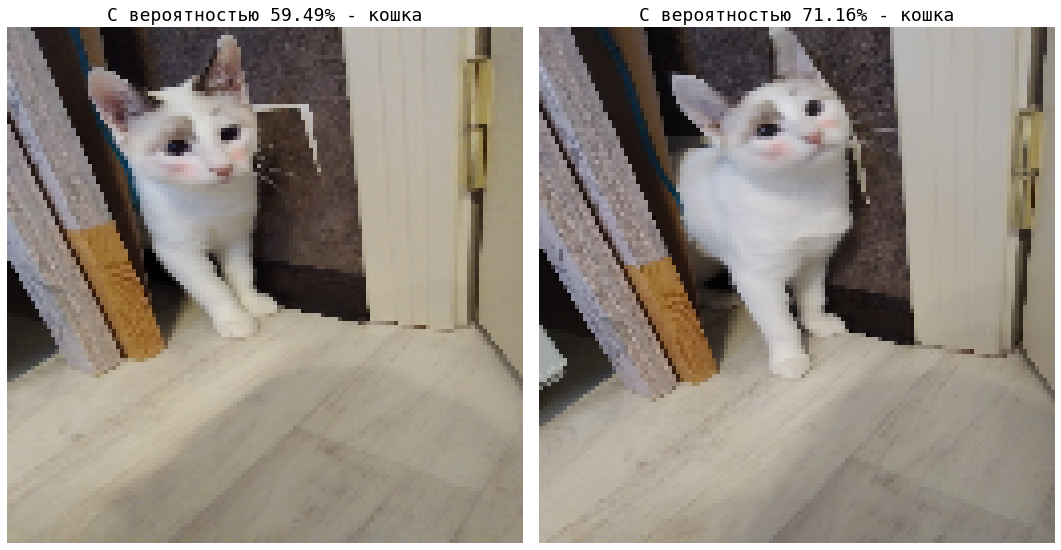

In [60]:
plt.figure(figsize=(15, 15))
for i in range(len(example_df)):
    plt.subplot(1, 2, i+1)
    image = example_generator[0][i]
    plt.imshow(image)
    plt.axis('off')
    
    image = np.expand_dims(image, axis=0)
    prediction = model_pretrained.predict(image)

    if prediction[0][0] > prediction[0][1]:
        plt.title('С вероятностью ' + str(np.round(prediction[0][0]*100, decimals=2)) + '% - кошка')
    elif prediction[0][1] > prediction[0][0]:
        plt.title('С вероятностью ' + str(np.round(prediction[0][1]*100, decimals=2)) + '% - собака')
    
plt.tight_layout()
plt.show()